 Fee Investigation

 Uniswap charges flat fee structures in V3, either 1bp, 5bps, 30bps, or more. Uniswap V2 charged about 15bps. We are investigating how much we can shrink fees in times of lower volatility or smaller trades

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
resp = requests.get('https://api.kraken.com/0/public/Depth?pair=ETHUSDC')

In [4]:
data = resp.json()['result']['ETHUSDC']

In [5]:
asks = data['asks']
asks[:3][:3]

[['3606.450000', '6.933', 1710619994],
 ['3606.900000', '0.549', 1710619994],
 ['3607.260000', '1.936', 1710619994]]

In [6]:
bids = data['bids']
bids[:3][:3]

[['3606.010000', '0.549', 1710619994],
 ['3605.740000', '6.934', 1710619994],
 ['3605.240000', '1.097', 1710619994]]

In [7]:
spread = float(asks[0][0])-float(bids[0][0])
spread

0.4399999999995998

In [47]:
def get_vol()->float:
    return 60

def get_trade_volume()->float:
    return 150

ETH_PRICE = 3700

In [9]:
def get_current_fee(x):
    global ETH_PRICE
    return ETH_PRICE*0.0015*x/x

In [10]:
def get_fee(volume: float,volatility: float)->float:
    'Returns fee per lot of transaction'
    standard_eth_volume = 150
    scaled_volume = volume/150
    longterm_eth_volatility = 60 # Out of intuition, do not know for sure
    scaled_vol = volatility/longterm_eth_volatility
    constant_factor = 2

    fee_per_lot = constant_factor*scaled_volume*scaled_vol**2+3.5
    # fee_per_lot = min_fee_per_lot+volume_discount*(np.power(scaled_vol,2) + scaled_vol)
    
    return fee_per_lot

In [11]:
def get_percentage_fee(fee):
    global ETH_PRICE
    return 100*fee/(ETH_PRICE)

In [48]:
get_fee(get_trade_volume(), get_vol())

5.5

In [13]:
# Fee USDC/ETH for a trade of 0 size at 60% market volatility
get_fee(0,60)

3.5

In [14]:
# Fee USDC/ETH for a trade of 150 ETH at 60% market volatility
get_fee(150,60)

5.5

In [15]:
# Fee USDC/ETH for a trade of 150 ETH at 20% market volatility
get_fee(150,20)

3.7222222222222223

In [16]:
# Fee USDC/ETH for a trade of 150 ETH at 120% market volatility
get_fee(150,120)

11.5

In [17]:
# Current Fee charged by Uniswap
get_current_fee(2)

5.55

Plots

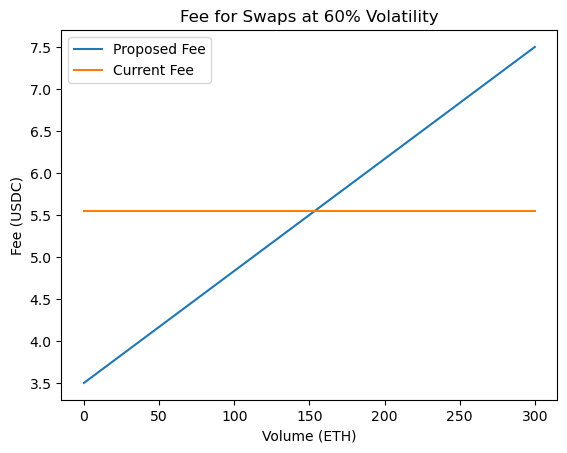

In [19]:
# x is volume
x = np.geomspace(0.0001, 300, 100)
proposed_fee = get_fee(x,60)
current_fee = get_current_fee(x)

plt.plot(x, proposed_fee, label='Proposed Fee')
plt.plot(x, current_fee, label='Current Fee')

# Add labels and title
plt.xlabel('Volume (ETH)')
plt.ylabel('Fee (USDC)')
plt.title('Fee for Swaps at 60% Volatility')
plt.legend()

# Show the plot
plt.savefig('fees_vs_size.png')
plt.show()

Scaling fees with volatility:

Due to the lack of data, we have to approximate some cases.

We run on the assumption of 60 being the stable long term volatility of ETH. We also run on the assumption that 150ETH is a standard lot size on spot for ETH (based on assumptions explained at the bottom of this notebook). At 60 vol and a size of 150 ETH, we think we can run on the standard edge  of 15bps (or around 5.5USDC). At closer to 0 vol, we think we should charge less, and we put it at 3.5$ USDC for now.

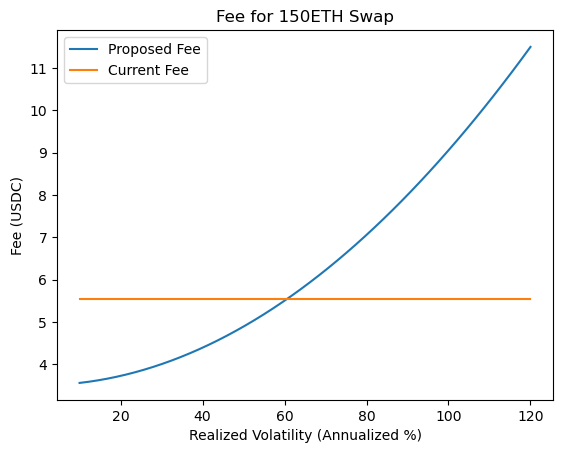

In [20]:
# y is annualized volatility
y = np.linspace(10, 120, 50)
proposed_fee = get_fee(150,y)
current_fee = get_current_fee(y)

plt.plot(y, proposed_fee, label='Proposed Fee')
plt.plot(y, current_fee, label='Current Fee')

# Add labels and title
plt.xlabel('Realized Volatility (Annualized %)')
plt.ylabel('Fee (USDC)')
plt.title('Fee for 150ETH Swap')
plt.legend()

# Show the plot
plt.savefig('fees_vs_volatility.png')
plt.show()

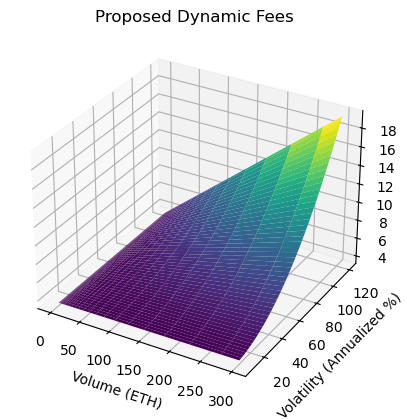

In [21]:
# x is volume
x = np.geomspace(0.01, 300, 100)
# y is volatility
y = np.linspace(8, 120, 100)
x, y = np.meshgrid(x, y)
z = get_fee(x,y)
# z = get_percentage_fee(fee, x)

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='viridis')

# Set labels and title
ax.set_xlabel('Volume (ETH)')
ax.set_ylabel('Volatility (Annualized %)')
ax.set_zlabel('Fee (USDC)')
ax.set_title('Proposed Dynamic Fees')

# Save and display plot
plt.savefig('proposed_fees.png')
plt.show()

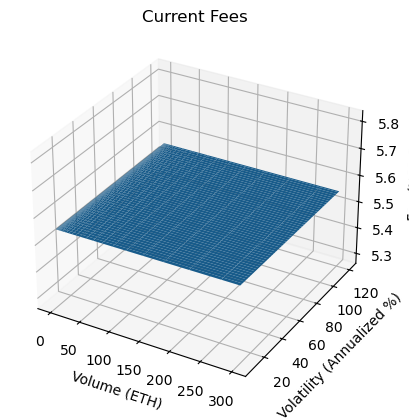

In [22]:
# x is volume
x = np.geomspace(0.01, 300, 100)
# y is volatility
y = np.linspace(8, 120, 100)
x, y = np.meshgrid(x, y)
z = get_current_fee(x)
# z = get_percentage_fee(fee, x)

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z)

# Set labels and title
ax.set_xlabel('Volume (ETH)')
ax.set_ylabel('Volatility (Annualized %)')
ax.set_zlabel('Fee (USDC)')
ax.set_title('Current Fees')

plt.savefig('current_fees.png')
plt.show()


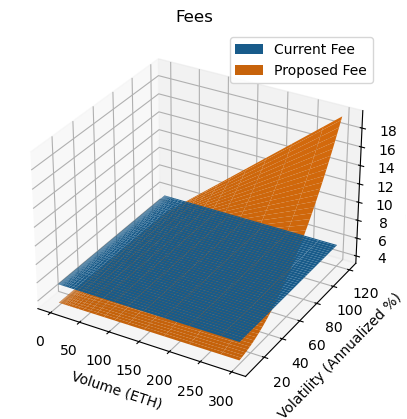

In [33]:
# x is volume
x = np.geomspace(0.01, 300, 100)
# y is volatility
y = np.linspace(8, 120, 100)
x, y = np.meshgrid(x, y)
proposed_fee = get_fee(x,y)
current_fee = get_current_fee(x)
# z = get_percentage_fee(fee, x)

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, current_fee, label="Current Fee")
ax.plot_surface(x, y, proposed_fee, label="Proposed Fee")


# Set labels and title
ax.set_xlabel('Volume (ETH)')
ax.set_ylabel('Volatility (Annualized %)')
ax.set_zlabel('Fee (USDC)')
ax.set_title('Fees')
plt.legend()

plt.savefig('compare_fees.png')
plt.show()


Order Book Liquidity

Here we are looking at the liquidity per volume on the orderbook
We have just taken an individual timestamp for the time being

We look at the midpoint price to see how far the bids/asks are away

In [34]:
price = (float(asks[0][0])-float(bids[0][0]))/2+float(bids[0][0])
price

3606.23

In [35]:
test_asks = np.array(asks).astype(np.float64)

In [36]:
test_bids = np.array(bids).astype(np.float64)

In [37]:
cum_volume = np.cumsum(test_asks[:,1]).reshape(-1,1)

In [38]:
cum_volume_bids = np.cumsum(test_bids[:,1]).reshape(-1,1)

In [39]:
test_asks_final = np.append(test_asks, cum_volume, axis=1)

In [40]:
test_bids_final = np.append(test_bids, cum_volume_bids, axis=1)

In [41]:
test_asks_final[:,0] = test_asks_final[:,0]-price

In [42]:
test_bids_final[:,0] = price-test_bids_final[:,0]

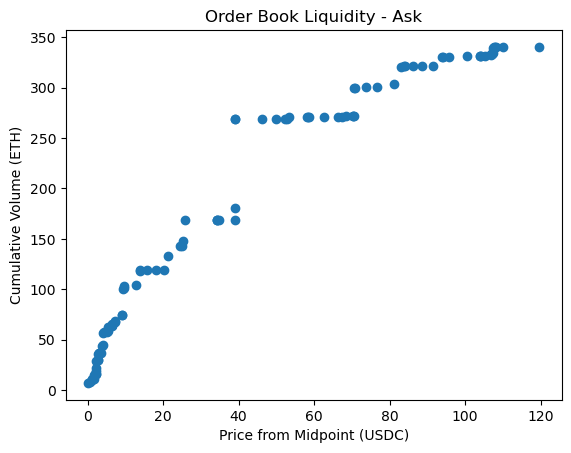

In [45]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = test_asks_final[:,0]
y = test_asks_final[:,3]

ax.scatter(x, y)

# Set labels and title
ax.set_xlabel('Price from Midpoint (USDC)')
ax.set_ylabel('Cumulative Volume (ETH)')
ax.set_title('Order Book Liquidity - Ask')

plt.savefig('orderbook_liquidity_ask.png')
plt.show()


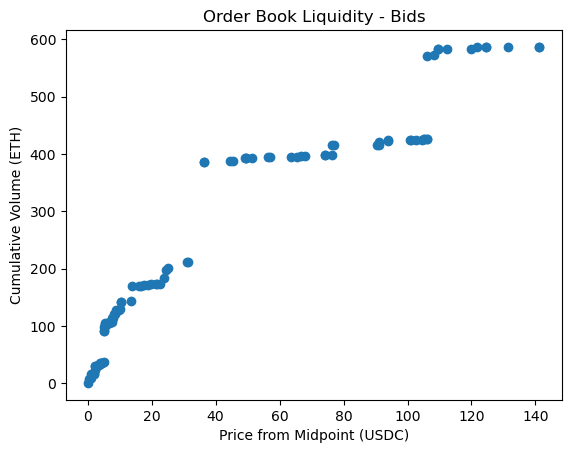

In [46]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = test_bids_final[:,0]
y = test_bids_final[:,3]

ax.scatter(x, y)

# Set labels and title
ax.set_xlabel('Price from Midpoint (USDC)')
ax.set_ylabel('Cumulative Volume (ETH)')
ax.set_title('Order Book Liquidity - Bids')

plt.savefig('orderbook_liquidity_bid.png')
plt.show()


Hard part is that our price moves because of the invariant function, so how do we discretize the final distribution of price due fees or due to the invariant function? For simplicity, we will operate on the assumption that smaller orders are less toxic and that we want smaller orders, hence we will reduce fees for orders under a certain size. It looks like the first 150 ETH on the orderbook is pretty liquid, so we will simply put that orders < 150 ETH will be rewarded and orders above will be charged slightly more. For now, we can do a simple scale where orders smaller than 150 ETH will have scaled fees down to 60%. For rough guidance, we think the charge per ETH at around a swap of 0 ETH can be 3.5 USDC and one at 150ETH at a normal volatility of 60 can be 5.5 USDC (aroudn what is currently being charged)